In [6]:
import numpy as np
import pycuda.autoinit
import pycuda.driver as cuda
from pycuda import gpuarray, compiler
from osgeo import gdal
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from datetime import datetime


In [7]:
def printGPU():
    # Print available CUDA devices
    print("%d device(s) found." % cuda.Device.count())           
    for ordinal in range(cuda.Device.count()):
        dev = cuda.Device(ordinal)
        print("Device #%d: %s" % (ordinal, dev.name()))
    print(cuda)

In [8]:
def svfCalculator_RayTracingOnGPU(dsm, vegdem, vegdem2, scale, transparency_factor, svf_type, theta_start, theta_end):
    """
    Calculate Sky View Factor (SVF) using ray tracing on a GPU.

    Parameters:
        dsm (np.ndarray): Digital Surface Model.
        vegdem (np.ndarray): Vegetation height model.
        vegdem2 (np.ndarray): Vegetation canopy bottom height model.
        scale (float): Scale factor for the height.
        transparency_factor (float): Factor representing the transparency of vegetation.
        svf_type (int): Type of SVF calculation (0: DSM only, 1: Veg, 2: Veg & DSM).
        theta_start (int): Starting angle for theta in degrees.
        theta_end (int): Ending angle for theta in degrees.

    Returns:
        np.ndarray: Calculated Sky View Factor as a 2D array.
    """
    # Convert input arrays to float32
    px = np.array(dsm, dtype=np.float32)
    veg_px = np.array(vegdem, dtype=np.float32)
    veg_px2 = np.array(vegdem2, dtype=np.float32)
    height, width = px.shape

    # Allocate GPU memory
    d_px = gpuarray.to_gpu(px)
    d_veg_px = gpuarray.to_gpu(veg_px)
    d_veg_px2 = gpuarray.to_gpu(veg_px2)
    d_out = gpuarray.empty((height, width), np.float32)

    # CUDA kernel code for SVF calculation
    kernel_code = """
    #include <math.h>
    #define PI 3.141592654

    __global__ void svfcalculator(float *lattice_out, float *lattice, float *veg_lattice, float *veg_lattice2, 
                                   float scale, float transparency_factor, int width, int height, 
                                   int svf_type, int theta_start, int theta_end) {
        int ix = threadIdx.x + blockIdx.x * blockDim.x;
        int iy = threadIdx.y + blockIdx.y * blockDim.y;
        if (ix >= width || iy >= height) return;

        int index = ix + iy * width;
        float clr00 = lattice[index];
        float free_fraction_total = 0.0;

        // Precompute theta values
        float theta[180];
        for (int t = 0; t < 180; ++t) {
            theta[t] = PI * t / 180.0f;
        }

        // Loop over theta in the specified range
        for (int thetaN = theta_start; thetaN < theta_end; thetaN++) {
            float free_fraction = 1.0f;

            int gamma_steps = 90;
            float gamma_step_inv = 1.0f / float(gamma_steps);

            // Precompute gamma values
            float gamma[91];
            for (int g = 0; g <= gamma_steps; ++g) {
                gamma[g] = (PI / 2.0f) * g * gamma_step_inv;
            }

            for (int gammaN = 0; gammaN <= gamma_steps; gammaN++) {
                float radius = 1.0f;
                float cos_theta = cosf(theta[thetaN]);
                float sin_theta = sinf(theta[thetaN]);

                while (radius < 450.0f) {
                    int x = ix + int(radius * cos_theta);
                    int y = iy - int(radius * sin_theta);
                    if (x < 0 || x >= width || y < 0 || y >= height) break;
                    int index2 = x + y * width;

                    float dsm_height = lattice[index2];
                    float veg_height = veg_lattice[index2];
                    float canopy_bottom_height = veg_lattice2[index2];
                    float ray_height = clr00 + radius * tanf(gamma[gammaN]);

                    if (svf_type == 0 && ray_height < dsm_height) {
                        free_fraction -= gamma_step_inv;
                        break;
                    }
                    if (svf_type == 1 && ray_height > canopy_bottom_height && ray_height < veg_height) {
                        free_fraction -= (transparency_factor * gamma_step_inv);
                        break;
                    }
                    if (svf_type == 2) {
                        if (ray_height < dsm_height) break;
                        if (ray_height > canopy_bottom_height && ray_height < veg_height) continue;
                        if (ray_height < dsm_height) {
                            free_fraction -= (transparency_factor * gamma_step_inv);
                            break;
                        }
                    }
                    radius += 1.0f;
                }
            }
            free_fraction_total += free_fraction;
        }
        lattice_out[index] = free_fraction_total / float(theta_end - theta_start);
    }
    """

    # Compile the CUDA kernel
    mod = compiler.SourceModule(kernel_code)
    svf_kernel = mod.get_function("svfcalculator")

    # Define block and grid sizes
    block_size = (32, 32, 1)
    grid_size = (int(np.ceil(width / block_size[0])), int(np.ceil(height / block_size[1])))

    # Launch the kernel
    svf_kernel(
        d_out, d_px, d_veg_px, d_veg_px2, np.float32(scale), np.float32(transparency_factor),
        np.int32(width), np.int32(height), np.int32(svf_type),
        np.int32(theta_start), np.int32(theta_end),
        block=block_size, grid=grid_size
    )
    
    # Synchronize the CUDA context
    cuda.Context.synchronize()
    return d_out.get()

1 device(s) found.
Device #0: NVIDIA GeForce RTX 3050 Laptop GPU
<module 'pycuda.driver' from 'C:\\Users\\Max\\.conda\\envs\\svfscalc\\Lib\\site-packages\\pycuda\\driver.py'>


C:\Users\Max\AppData\Local\Temp\ipykernel_5596\1237348787.py:107: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu

  mod = compiler.SourceModule(kernel_code)


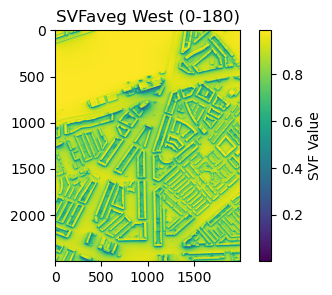

In [9]:
def main(dsm_path, vegdem_path, vegdem2_path, transparency_factor, output_dir):
    cuda.init()
    #printGPU()

    def plot_svf(svf_data, title):
        plt.figure(figsize=(5, 3))
        plt.imshow(svf_data, cmap='viridis')
        plt.colorbar(label='SVF Value')
        plt.title(title)
        plt.show()

    dsm_ds = gdal.Open(dsm_path)
    vegdem_ds = gdal.Open(vegdem_path)
    vegdem2_ds = gdal.Open(vegdem2_path)

    geotransform = dsm_ds.GetGeoTransform()
    scale = 1 / geotransform[1]

    dsm = dsm_ds.ReadAsArray().astype(np.float32)
    vegdem = vegdem_ds.ReadAsArray().astype(np.float32)
    vegdem2 = vegdem2_ds.ReadAsArray().astype(np.float32)

    vegdem = np.where(vegdem > 0, vegdem + dsm, vegdem)
    vegdem2 = np.where(vegdem2 > 0, vegdem2 + dsm, vegdem2)

    vegdem = gaussian_filter(vegdem, sigma=0.5)
    vegdem2 = gaussian_filter(vegdem2, sigma=0.5)

    timestamp = datetime.now().strftime("%H%M%S")
    driver = gdal.GetDriverByName('GTiff')

    def save_svf(filename, svf_data):
        out_ds = driver.Create(filename, dsm.shape[1], dsm.shape[0], 1, gdal.GDT_Float32)
        out_ds.GetRasterBand(1).WriteArray(svf_data)
        out_ds.SetGeoTransform(dsm_ds.GetGeoTransform())
        out_ds.SetProjection(dsm_ds.GetProjection())
        out_ds.FlushCache()

    # Bereken SVF per windrichting en sla op
    svf_w = svfCalculator_RayTracingOnGPU(dsm, vegdem, vegdem2, scale, transparency_factor, 0, 0, 180)
    save_svf(f"{output_dir}/svf_W_{timestamp}.tif", svf_w)
    svfveg_w = svfCalculator_RayTracingOnGPU(dsm, vegdem, vegdem2, scale, transparency_factor, 1, 0, 180)
    save_svf(f"{output_dir}/svfveg_W_{timestamp}.tif", svfveg_w)
    svfaveg_w = svfCalculator_RayTracingOnGPU(dsm, vegdem, vegdem2, scale, transparency_factor, 2, 0, 180)
    save_svf(f"{output_dir}/svfaveg_W_{timestamp}.tif", svfaveg_w)

    svf_s = svfCalculator_RayTracingOnGPU(dsm, vegdem, vegdem2, scale, transparency_factor, 0, 90, 270)
    save_svf(f"{output_dir}/svf_S_{timestamp}.tif", svf_s)
    svfveg_s = svfCalculator_RayTracingOnGPU(dsm, vegdem, vegdem2, scale, transparency_factor, 1, 0, 180)
    save_svf(f"{output_dir}/svfveg_S_{timestamp}.tif", svfveg_s)
    svfaveg_s = svfCalculator_RayTracingOnGPU(dsm, vegdem, vegdem2, scale, transparency_factor, 2, 0, 180)
    save_svf(f"{output_dir}/svfaveg_S_{timestamp}.tif", svfaveg_s)

    svf_e = svfCalculator_RayTracingOnGPU(dsm, vegdem, vegdem2, scale, transparency_factor, 0, 180, 360)
    save_svf(f"{output_dir}/svf_E_{timestamp}.tif", svf_e)
    svfveg_e = svfCalculator_RayTracingOnGPU(dsm, vegdem, vegdem2, scale, transparency_factor, 1, 0, 180)
    save_svf(f"{output_dir}/svfveg_E_{timestamp}.tif", svfveg_e)
    svfaveg_e = svfCalculator_RayTracingOnGPU(dsm, vegdem, vegdem2, scale, transparency_factor, 2, 0, 180)
    save_svf(f"{output_dir}/svfaveg_E_{timestamp}.tif", svfaveg_e)

    svf_n = svfCalculator_RayTracingOnGPU(dsm, vegdem, vegdem2, scale, transparency_factor, 0, 270, 90)
    save_svf(f"{output_dir}/svf_N_{timestamp}.tif", svf_n)
    svfveg_n = svfCalculator_RayTracingOnGPU(dsm, vegdem, vegdem2, scale, transparency_factor, 1, 0, 180)
    save_svf(f"{output_dir}/svfveg_N_{timestamp}.tif", svfveg_n)
    svfaveg_n = svfCalculator_RayTracingOnGPU(dsm, vegdem, vegdem2, scale, transparency_factor, 2, 0, 180)
    save_svf(f"{output_dir}/svfaveg_N_{timestamp}.tif", svfaveg_n)
    
    plot_svf(svf_w, 'SVF West (0-180)')
    plot_svf(svf_s, 'SVF South (90-270)')
    plot_svf(svf_e, 'SVF East (180-360)')
    plot_svf(svf_n, 'SVF North (270-90)')

    plot_svf(svfveg_w, 'SVFveg West (0-180)')
    plot_svf(svfveg_s, 'SVFveg South (90-270)')
    plot_svf(svfveg_e, 'SVFveg East (180-360)')
    plot_svf(svfveg_n, 'SVFveg North (270-90)')

    plot_svf(svfaveg_w, 'SVFaveg West (0-180)')
    plot_svf(svfaveg_s, 'SVFaveg South (90-270)')
    plot_svf(svfaveg_e, 'SVFaveg East (180-360)')
    plot_svf(svfaveg_n, 'SVFaveg North (270-90)')

if __name__ == "__main__":
    # Define file paths and parameters
    dsm_path = "C:/Users/Max/Documents/Werk/test_gpu/input/dsm_buildings_ground_37HN1_14.tif"       # DSM raster file path
    vegdem_path = "C:/Users/Max/Documents/Werk/test_gpu/input/cdsm_groundlvl_37HN1_14.tif"          # CDSM raster file path
    vegdem2_path = "C:/Users/Max/Documents/Werk/test_gpu/input/TDSM.tif"                            # TDSM raster file path
    transparency_factor = 0.97                                                                      # Transparency/opacity factor for vegetation impact
    output_dir = "C:/Users/Max/Documents/Werk/test_gpu/output/bigger_terr"                          # Output directory

    gdal.UseExceptions()
    main(dsm_path, vegdem_path, vegdem2_path, transparency_factor, output_dir)